In [1]:
import torch
import numpy as np
import pandas as pd
import os
import struct
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 256)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
Y_train = train["label"].values
X_train = train.drop(labels=["label"], axis=1).values
Y_test = test["label"].values
X_test = test.drop(labels=["label"], axis=1).values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
X_train_tensor = torch.Tensor(X_train).view(-1, 1, 28, 28)
X_test_tensor = torch.Tensor(X_test).view(-1, 1, 28, 28)
Y_train_tensor = torch.LongTensor(Y_train)
Y_test_tensor = torch.LongTensor(Y_test)

In [6]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
model = FCNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/20, Loss: 0.005293224142959484, Accuracy: 0.9984333333333333, Precision: 0.9774701903488532, Recall: 0.9774839096737393, F1 Score: 0.9774265036162666
Epoch 2/20, Loss: 0.0029520168427489574, Accuracy: 0.9991166666666667, Precision: 0.9803801980692279, Recall: 0.9804746560161431, F1 Score: 0.9804193683881651
Epoch 3/20, Loss: 0.004886876086964885, Accuracy: 0.9988, Precision: 0.9808746302809344, Recall: 0.9806592955012314, F1 Score: 0.9807574245605126
Epoch 4/20, Loss: 0.006247664400624676, Accuracy: 0.9984166666666666, Precision: 0.9792455766854566, Recall: 0.979032716308644, F1 Score: 0.9791096799795925
Epoch 5/20, Loss: 0.0026090757157614186, Accuracy: 0.9992833333333333, Precision: 0.9771517819646176, Recall: 0.9766468160752503, F1 Score: 0.9767867610160854
Epoch 6/20, Loss: 0.00533544948307646, Accuracy: 0.9984666666666666, Precision: 0.9803705384829842, Recall: 0.9798228016351173, F1 Score: 0.9800206933185892
Epoch 7/20, Loss: 0.003924314886752988, Accuracy: 0.9989, Precis

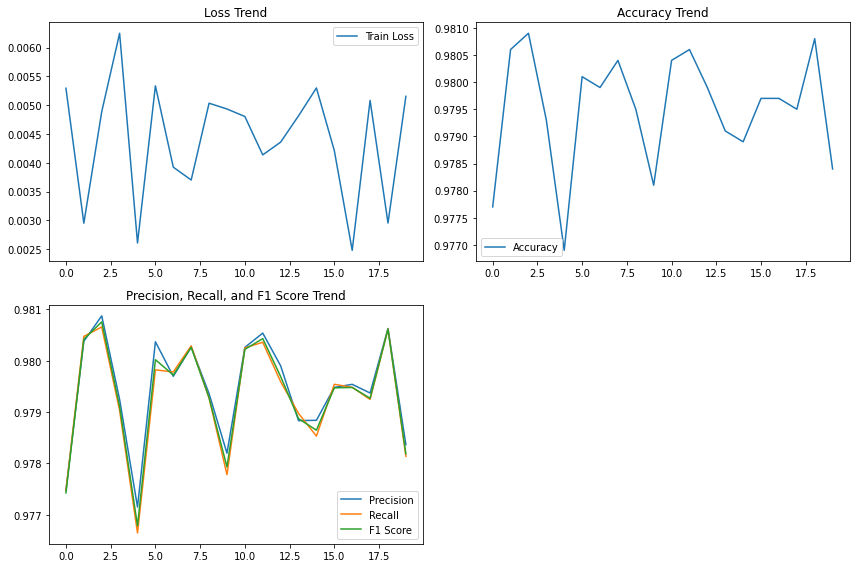

In [19]:
num_epochs = 20
history = {'train_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
num_classes = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    correct1 = 0
    total1 = 0 
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    model.eval()
    tp = [0] * num_classes
    fp = [0] * num_classes
    fn = [0] * num_classes
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total1 += labels.size(0)
            correct1 += (predicted == labels).sum().item()
            
            for i in range(len(labels)):
                if labels[i] == predicted[i]:
                    tp[labels[i]] += 1
                else:
                    fp[predicted[i]] += 1
                    fn[labels[i]] += 1
    
    precision = [tp[i] / (tp[i] + fp[i]) if (tp[i] + fp[i]) > 0 else 0 for i in range(num_classes)]
    recall = [tp[i] / (tp[i] + fn[i]) if (tp[i] + fn[i]) > 0 else 0 for i in range(num_classes)]
    f1_score = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0 for i in range(num_classes)]
    
    avg_precision = sum(precision) / num_classes
    avg_recall = sum(recall) / num_classes
    avg_f1_score = sum(f1_score) / num_classes
    
    history['train_loss'].append(running_loss / len(train_loader))
    history['accuracy'].append(correct1 / total1)
    history['precision'].append(avg_precision)
    history['recall'].append(avg_recall)
    history['f1_score'].append(avg_f1_score)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total}, Precision: {avg_precision}, Recall: {avg_recall}, F1 Score: {avg_f1_score}')

# 绘图
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.legend()
plt.title('Loss Trend')

plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Trend')

plt.subplot(2, 2, 3)
plt.plot(history['precision'], label='Precision')
plt.plot(history['recall'], label='Recall')
plt.plot(history['f1_score'], label='F1 Score')
plt.legend()
plt.title('Precision, Recall, and F1 Score Trend')

plt.tight_layout()
plt.show()